In [321]:
import sys
import numpy as np
import math

from tqdm import tqdm

import flory

sys.path.append('../..')
print(np.__version__)


import matplotlib.pyplot as plt
import mpltern
#import matplotlib as mpl
import matplotlib as mpl

from mpltern.datasets import get_shanon_entropies

import importlib

from scipy import cluster, spatial

from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.optimize import differential_evolution

#sys.path.append('/Users/calvinsmith/dufresne_lab/lab_work/llps_classification')
import flory_generate as gen
import flory_plots as plots
importlib.reload(gen)
importlib.reload(plots)

2.0.0


<module 'flory_plots' from '/Users/calvinsmith/dufresne_lab/lab_work/llps_classification/flory_plots.py'>

# FloryClassifier Class



In [480]:
class FloryClassifier:
    
    def __init__(self):
        self.phi_in_thresh = 0.2
        self.phi_H_thresh = 0.1
        self.phi_out = 0.1
        self.phi_in_range = [0.02,0.4]
        self.phi_in_vector = [0.1,0.05]
        self.phi_out_vector = [0.05,0.05]
        self.num_of_points = 6
        self.chi_strength = 10
        self.H_dim = 2
        self.num_comps = self.H_dim + 2
        self.phi_in_min = 0.1
        self.chi_matrix = gen.chi_matrix_w_sol(self.num_comps,self.chi_strength)
        self.chi_matrix_multi = gen.chi_matrix_w_sol(self.num_comps + 1,self.chi_strength)
        self.chi_matrix_custom = [[],[]]
        print(self.chi_matrix_multi)

        
        

    '''Goal Function '''
    def step_func(self,x):
        if x >= 0.5:
            return 0
        elif 0 <= x < 0.5:
            return 1
        else: 
            raise Exception("Sorry, no numbers below zero")
            
    '''Calculate the Loss'''
    def calc_loss(self,points):
        loss = 0
        for point in points:
            loss += (self.step_func(point[0]) - point[1])**2
            
        return loss
    
    ''' Readout Function
    def output_readout_func(self, phi_in, phi_out):
        x = math.exp(-(phi_in/phi_out))
        return x
    ''' 
    def phi_out_readout_func(self,phi_out):
        #x = phi_out[0]/sum(phi_out)
        x = phi_out[0] - phi_out[1]
        x = x/sum(phi_out) 
        x = 1.2*math.tanh(3*x)
        return abs(x)
    
    def evolve_components_flory(self, phi_H):
        num_comps = len(phi_H) + 2
        #generate comp_points
        
        
        # picks all the phi_in points given the threshold
        phi_in_points = np.linspace(self.phi_in_min,self.phi_in_thresh, self.num_of_points)
        phi_in_points = phi_in_points.reshape(self.num_of_points,1)
        # 
        phi_H_points = np.tile(phi_H, [self.num_of_points,1])
        out_array = self.phi_out*np.ones((self.num_of_points,1))
        # comp_points is all the points in the phase space that we are going to evolve
        comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
        #add solvent component
        phi_sol_points = []
        for phi_in in phi_in_points:
            phi_sol= 1 - (phi_in + self.phi_out + sum(phi_H))
            if phi_sol < 0:
                raise Exception("No Negative Solvent")
            phi_sol_points.append(phi_sol)
    
        phi_sol_points = np.array(phi_sol_points)
    
        comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
        print(comp_points)
        norm_points = np.linspace(0,1, self.num_of_points)
    
        evolved_comp_points = []
        for point in tqdm(comp_points):
            phase = flory.find_coexisting_phases(self.num_comps+1,self.chi_matrix,point, progress = False)
            evolved_comp_points.append(phase)

        dilute_comp_points = []
        for phase in evolved_comp_points:
            x = gen.most_dilute_flory(phase)
            dilute_comp_points.append(x)
        
        dilute_out_comp_arr = np.array(dilute_comp_points)
    
        test_plot = plots.plot_comp_volume_fraction_v2(dilute_out_comp_arr,self.output_readout_func)
    
        
        return dilute_out_comp_arr
    
    def plot_data_v3(self, data):
        '''
        Plots each of the components of the volume fraction as a scatter plot 
        Data is a numpy array
        '''
        num_comps = data.shape[1]
        num_of_points = data.shape[0]
        norm_points = norm_points = np.linspace(0,1, self.num_of_points)
    
        
        # Customize the plot
        plt.title('Plot of Component Volume Fractions')
        plt.xlabel('Initial Phi_In')
        plt.ylabel('Volume Fraction')
        plt.ylim(-1, 1)
        
        # Create scatter plot for the first set of y-values
        for i in range(1,(self.num_comps)-2):
            plt.scatter(norm_points, data[:,i], color='green', marker='o', label = f'Phi_H {i}')
        plt.scatter(norm_points,data[:,0], color='blue', marker='o',label = 'Phi_In')
        
        for i in range(len(self.phi_out_vector)):
            plt.scatter(norm_points, data[:,-i-2], color='red', marker='o', label = f'Phi_Out {i+1}')
        plt.scatter(norm_points, data[:,-1], color='yellow', marker='o', label = 'Phi_Sol')

        
        output_comp_points = []
        for point in data:
            out_point = point[-len(self.phi_out_vector)-1:-1]
            #print(out_point)
            x = self.phi_out_readout_func(out_point)
            output_comp_points.append(x)
            
        output_comp_points = np.array(output_comp_points)
        plt.scatter(norm_points,output_comp_points, color = 'purple', marker='x')
        plt.plot(norm_points,output_comp_points, color = 'purple', linewidth = 2.0, label = 'Readout Value')
        plt.legend()
        # Show plot
        plt.show()
    

    def evolve_components_flory_multi(self,phi_H):
        self.num_comps = len(phi_H) + len(self.phi_out_vector) +1
        #generate comp_points
        print(self.phi_out_vector)
        phi_in_min = self.phi_in_range[0]
        phi_in_max = self.phi_in_range[1]
        # picks all the phi_in points given the threshold
        phi_in_points = np.linspace(phi_in_min,phi_in_max, self.num_of_points)
        phi_in_points = phi_in_points.reshape(self.num_of_points,1)
        # 
        phi_H_points = np.tile(phi_H, [self.num_of_points,1])
        out_array = np.tile(self.phi_out_vector, [self.num_of_points, 1])
    
            
        # comp_points is all the points in the phase space that we are going to evolve
        comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
        #add solvent component
        phi_sol_points = []
        for phi_in in phi_in_points:
            phi_sol= 1 - (phi_in + sum(self.phi_out_vector) + sum(phi_H)) 
            if phi_sol < 0:
                raise Exception("No Negative Solvent")
            phi_sol_points.append(phi_sol)
    
        phi_sol_points = np.array(phi_sol_points)
    
        comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
        print(comp_points)
        norm_points = np.linspace(0,1, self.num_of_points)
    
        evolved_comp_points = []
        for point in tqdm(comp_points):
            phase = flory.find_coexisting_phases(self.num_comps+1,self.chi_matrix_multi,point, progress = False)
            print(f"Number of Phases {len(phase.fractions)}")
            print(f"Phase Fractions + {phase.fractions}")
            print(f"Phase Volumes + {phase.volumes}")
            evolved_comp_points.append(phase)
    
        dilute_comp_points = []
        for phase in evolved_comp_points:
            x = gen.most_dilute_flory(phase)
            dilute_comp_points.append(x)
        
        dilute_out_comp_arr = np.array(dilute_comp_points)

        print(f"Data: {dilute_out_comp_arr[0:4]}")
        
        test_plot = self.plot_data_v3(dilute_out_comp_arr)
    
        
        return dilute_out_comp_arr
        

    

           

    def evolve_components_flory_multi_clean(self,phi_H):
        self.num_comps = len(phi_H) + len(self.phi_out_vector) +1
        #generate comp_points
        #print(self.phi_out_vector)
        phi_in_min = self.phi_in_range[0]
        phi_in_max = self.phi_in_range[1]
        # picks all the phi_in points given the threshold
        phi_in_points = np.linspace(phi_in_min,phi_in_max, self.num_of_points)
        phi_in_points = phi_in_points.reshape(self.num_of_points,1)
        # 
        phi_H_points = np.tile(phi_H, [self.num_of_points,1])
        out_array = np.tile(self.phi_out_vector, [self.num_of_points, 1])
    
            
        # comp_points is all the points in the phase space that we are going to evolve
        comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
        #add solvent component
        phi_sol_points = []
        for phi_in in phi_in_points:
            phi_sol= 1 - (phi_in + sum(self.phi_out_vector) + sum(phi_H)) 
            if phi_sol < 0:
                raise Exception("No Negative Solvent")
            phi_sol_points.append(phi_sol)
    
        phi_sol_points = np.array(phi_sol_points)
    
        comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
        #print(comp_points)
        norm_points = np.linspace(0,1, self.num_of_points)
    
        evolved_comp_points = []
        for point in tqdm(comp_points):
            phase = flory.find_coexisting_phases(self.num_comps+1,self.chi_matrix_multi,point, progress = False)
            #print(f"Number of Phases {len(phase.fractions)}")
            #print(f"Phase Fractions + {phase.fractions}")
            #print(f"Phase Volumes + {phase.volumes}")
            evolved_comp_points.append(phase)
    
        dilute_comp_points = []
        for phase in evolved_comp_points:
            x = gen.most_dilute_flory(phase)
            dilute_comp_points.append(x)
        
        dilute_out_comp_arr = np.array(dilute_comp_points)

        #print(f"Data: {dilute_out_comp_arr[0:4]}")
        
        test_plot = self.plot_data_v3(dilute_out_comp_arr)
    
        
        return dilute_out_comp_arr
        

    
        

In [481]:

test = FloryClassifier()


[[ 0.         10.61437994 12.20058288  8.53705523 10.0721177   0.        ]
 [10.61437994  0.          7.95940408 10.34379783  9.46144829  0.        ]
 [12.20058288  7.95940408  0.         10.52296251 10.9374435   0.        ]
 [ 8.53705523 10.34379783 10.52296251  0.         10.1149377   0.        ]
 [10.0721177   9.46144829 10.9374435  10.1149377   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.27s/it]


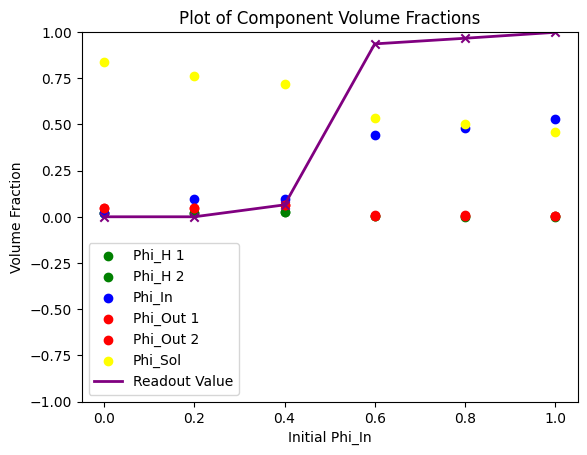

100%|█████████████████████████████████████████████| 6/6 [00:33<00:00,  5.63s/it]


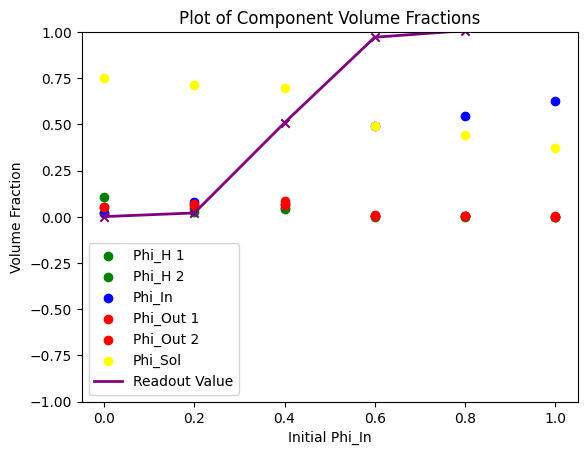

100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.68s/it]


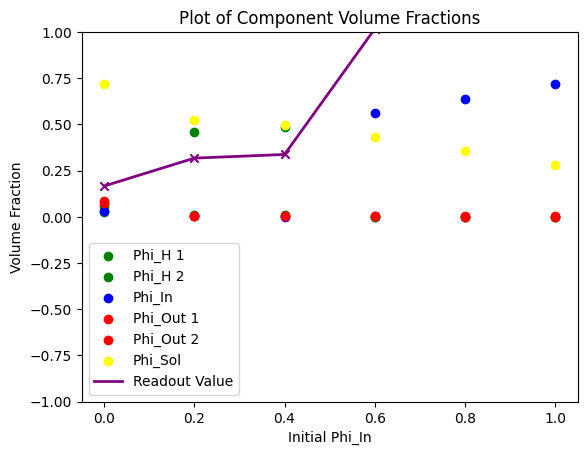

100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.70s/it]


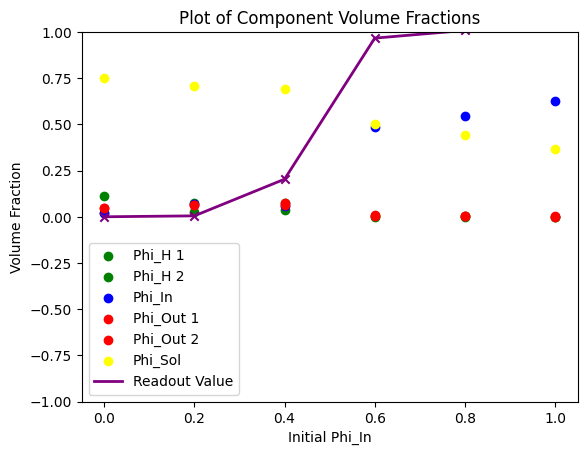

100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.85s/it]


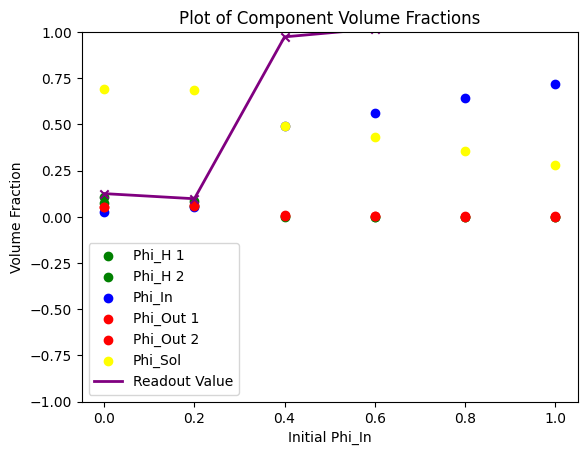

100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.04s/it]


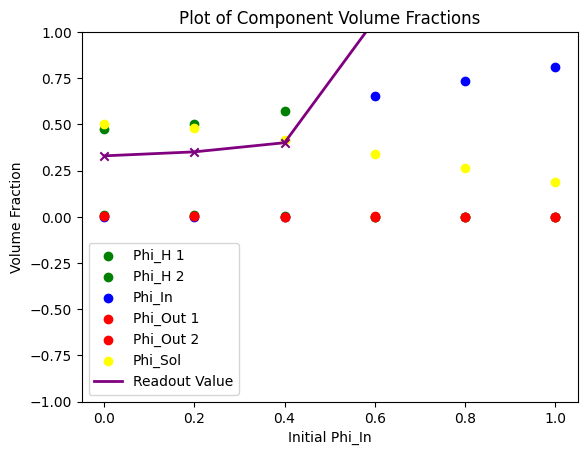

100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.42s/it]


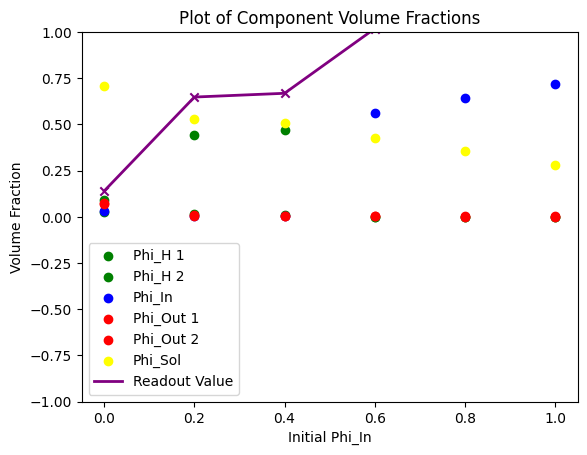

100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.07s/it]


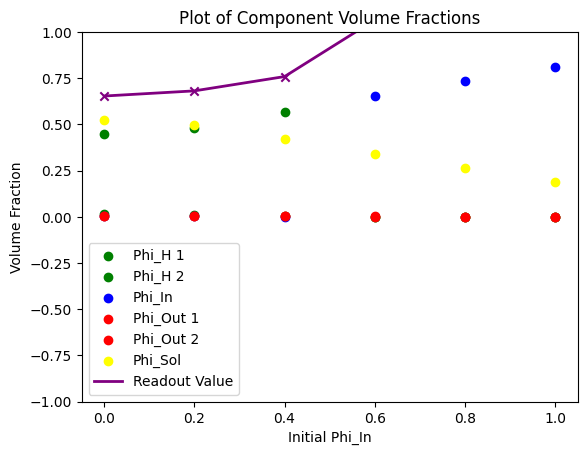

100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.58s/it]


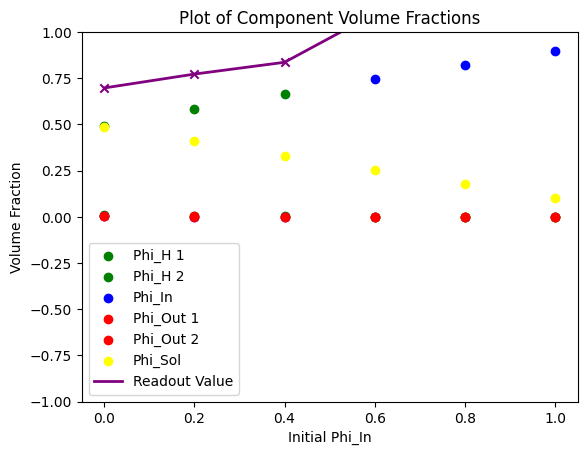

In [482]:

phi_H_test_x = np.linspace(0.02,0.2,3)
phi_H_test_y = np.linspace(0.02,0.2,3)

for x in phi_H_test_x:
    for y in phi_H_test_y:
        phi_H = [x,y]
        test.evolve_components_flory_multi_clean(phi_H)

100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.62s/it]


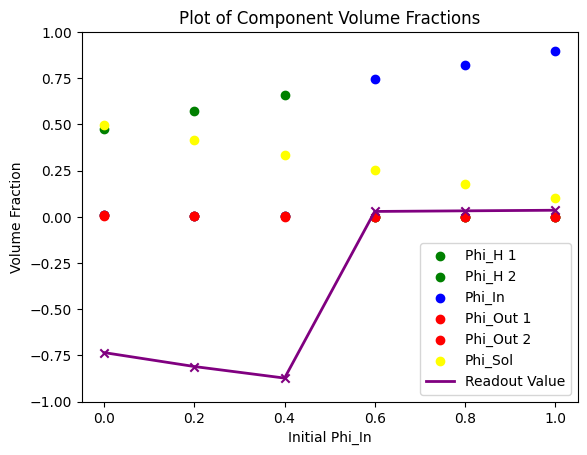

array([[9.28658411e-03, 4.73849589e-01, 7.27659715e-03, 5.46434960e-03,
        8.87095841e-03, 4.95251796e-01],
       [4.79774887e-03, 5.70906758e-01, 3.59044082e-03, 2.60862134e-03,
        4.57235461e-03, 4.13524128e-01],
       [2.60396475e-03, 6.58705050e-01, 1.86818379e-03, 1.30729219e-03,
        2.46941858e-03, 3.33046107e-01],
       [7.46811646e-01, 1.39547081e-03, 3.80250056e-04, 2.08627153e-04,
        2.05309268e-04, 2.50998701e-01],
       [8.23189572e-01, 8.04756976e-04, 1.92605791e-04, 9.94740005e-05,
        9.77105641e-05, 1.75615941e-01],
       [8.99469273e-01, 4.61233650e-04, 9.68869808e-05, 4.70911645e-05,
        4.61737159e-05, 9.98793418e-02]])

In [479]:
test.evolve_components_flory_multi_clean([0.2,0.2])

In [483]:
def optimize_Flory(fc):
    
    def evolve_flory_calc_loss(phi_H): 
        if gen.in_bounds(phi_H,fc.phi_H_thresh):
            print("IN BOUNDS")
            results = fc.evolve_components_flory_multi(phi_H)
            output_comp_points = np.zeros((fc.num_of_points,2))
            count = 0
            phi_init = np.linspace(0,1, fc.num_of_points)
            for point in results:
                x = fc.phi_out_readout_func(point[-3:-1])
                output_comp_points[count,:] = [phi_init[count],x]
                count+=1
            
            
            loss = fc.calc_loss(output_comp_points)
            print(f"LOSS: {loss}")
    
            return loss
        else:
            #This is if it is out of bounds, supposed to disincentivize going out of bounds
            print("OUT OF BOUNDS")
            return 10000

    bounds_range = [0,fc.phi_H_thresh]
    bounds = np.tile(bounds_range, [fc.H_dim,1] )
    result_DE = differential_evolution(evolve_flory_calc_loss,bounds = bounds, maxiter = 5, popsize = 4)



OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[0.05, 0.05]
[[0.02       0.00759645 0.00579633 0.05       0.05       0.86660722]
 [0.096      0.00759645 0.00579633 0.05       0.05       0.79060722]
 [0.172      0.00759645 0.00579633 0.05       0.05       0.71460722]
 [0.248      0.00759645 0.00579633 0.05       0.05       0.63860722]
 [0.324      0.00759645 0.00579633 0.05       0.05       0.56260722]
 [0.4        0.00759645 0.00579633 0.05       0.05       0.48660722]]


 17%|███████▌                                     | 1/6 [00:00<00:00,  6.06it/s]

Number of Phases 1
Phase Fractions + [[0.02       0.00759645 0.00579633 0.05       0.05       0.86660722]]
Phase Volumes + [1.]
Number of Phases 1
Phase Fractions + [[0.096      0.00759645 0.00579633 0.05       0.05       0.79060722]]
Phase Volumes + [1.]


 50%|██████████████████████▌                      | 3/6 [00:08<00:11,  3.69s/it]

Number of Phases 3
Phase Fractions + [[0.14638346 0.00860312 0.00667689 0.05643452 0.05599334 0.72590865]
 [0.25460669 0.00459923 0.00317587 0.03125151 0.02461464 0.68175209]
 [0.01409009 0.00403761 0.00263263 0.0112015  0.32448682 0.64355143]]
Phase Volumes + [0.74945074 0.24431804 0.00623121]


 67%|██████████████████████████████               | 4/6 [00:14<00:09,  4.78s/it]

Number of Phases 3
Phase Fractions + [[0.36536036 0.00320723 0.00190902 0.018874   0.0100891  0.60056027]
 [0.09650996 0.01534694 0.01270089 0.10777133 0.05766626 0.71000463]
 [0.00789511 0.00402028 0.00238605 0.00772261 0.39574695 0.58222901]]
Phase Volumes + [0.58304351 0.35758222 0.05937428]


 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:05,  5.88s/it]

Number of Phases 4
Phase Fractions + [[0.43413784 0.00324156 0.00181108 0.0117731  0.00576121 0.54327523]
 [0.07608003 0.03697917 0.03215092 0.09274283 0.06279594 0.69925112]
 [0.01312752 0.00419003 0.00429197 0.41828498 0.00644048 0.55366498]
 [0.00531567 0.00509872 0.00293136 0.00521545 0.44404276 0.53739605]]
Phase Volumes + [0.72166779 0.12241124 0.07102381 0.08489716]


100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.54s/it]

Number of Phases 4
Phase Fractions + [[0.50858371 0.00240998 0.00117311 0.0070172  0.00311184 0.47770416]
 [0.0075125  0.00303212 0.00302064 0.49873779 0.00330734 0.48438961]
 [0.00306292 0.0043737  0.00223009 0.00299825 0.510544   0.47679102]
 [0.03194237 0.11443109 0.09993892 0.04233156 0.04354061 0.66781547]]
Phase Volumes + [0.7819274  0.08495983 0.08884296 0.04426981]
Data: [[0.02       0.00759645 0.00579633 0.05       0.05       0.86660722]
 [0.096      0.00759645 0.00579633 0.05       0.05       0.79060722]
 [0.14638346 0.00860312 0.00667689 0.05643452 0.05599334 0.72590865]
 [0.36536036 0.00320723 0.00190902 0.018874   0.0100891  0.60056027]]


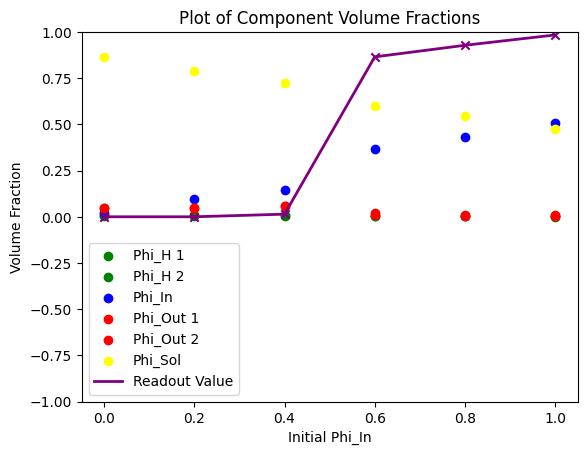

LOSS: 5.5500924128058875
IN BOUNDS
[0.05, 0.05]
[[0.02       0.03729012 0.03030099 0.05       0.05       0.81240889]
 [0.096      0.03729012 0.03030099 0.05       0.05       0.73640889]
 [0.172      0.03729012 0.03030099 0.05       0.05       0.66040889]
 [0.248      0.03729012 0.03030099 0.05       0.05       0.58440889]
 [0.324      0.03729012 0.03030099 0.05       0.05       0.50840889]
 [0.4        0.03729012 0.03030099 0.05       0.05       0.43240889]]


 17%|███████▌                                     | 1/6 [00:00<00:00,  6.10it/s]

Number of Phases 1
Phase Fractions + [[0.02       0.03729012 0.03030099 0.05       0.05       0.81240889]]
Phase Volumes + [1.]
Number of Phases 1
Phase Fractions + [[0.09600002 0.03729012 0.03030099 0.05       0.04999999 0.73640889]]
Phase Volumes + [1.]


 50%|██████████████████████▌                      | 3/6 [00:03<00:05,  1.69s/it]

Number of Phases 2
Phase Fractions + [[0.43053778 0.00369734 0.00200913 0.01074763 0.005791   0.54721714]
 [0.07034222 0.0504989  0.04142543 0.06543414 0.0673831  0.7049162 ]]
Phase Volumes + [0.28222941 0.71777059]


 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.27s/it]


KeyboardInterrupt: 

In [484]:
optimize_Flory(test)

# Step Function, Loss Function, Readout Function

In [311]:



    '''Goal Function '''
    def step_func(self,x):
        if x >= 0.5:
            return 0
        elif 0 <= x < 0.5:
            return 1
        else: 
            raise Exception("Sorry, no numbers below zero")
            
    '''Calculate the Loss'''
    def calc_loss(self,points):
        loss = 0
        for point in points:
            loss += (self.step_func(point[0]) - point[1])**2
            
        return loss
    
    ''' Readout Function '''
    def output_readout_func(self, phi_in, phi_out):
        x = math.exp(-(phi_in/phi_out))
        return x




# Main Function 
Takes phi_in_thresh, phi_out, phi_H, num_of_points, chi_strenght as parameters and returns a list of the most dilute phases from each point(dilute_comp_arr)


In [415]:
def evolve_components_flory(phi_in_thresh, phi_out, phi_H, num_of_points,chi_strength,chi_matrix):
    num_comps = len(phi_H) + 2
    #generate comp_points
    
    phi_in_min = 0.1
    # picks all the phi_in points given the threshold
    phi_in_points = np.linspace(phi_in_min,phi_in_thresh, num_of_points)
    phi_in_points = phi_in_points.reshape(num_of_points,1)
    # 
    phi_H_points = np.tile(phi_H, [num_of_points,1])
    out_array = phi_out*np.ones((num_of_points,1))
    # comp_points is all the points in the phase space that we are going to evolve
    comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
    #add solvent component
    phi_sol_points = []
    for phi_in in phi_in_points:
        phi_sol= 1 - (phi_in + phi_out + sum(phi_H)) 
        phi_sol_points.append(phi_sol)

    phi_sol_points = np.array(phi_sol_points)

    comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
    print(comp_points)
    norm_points = np.linspace(0,1, num_of_points)

    evolved_comp_points = []
    for point in (comp_points):
        phase = flory.find_coexisting_phases(num_comps+1,chi_matrix,point, progress = False)
        evolved_comp_points.append(phase)

    dilute_comp_points = []
    for phase in evolved_comp_points:
        x = gen.most_dilute_flory(phase)
        dilute_comp_points.append(x)
    
    dilute_out_comp_arr = np.array(dilute_comp_points)

    test_plot = plots.plot_comp_volume_fraction_v2(dilute_out_comp_arr,output_readout_func)

    
    return dilute_out_comp_arr
    

    
            

# Wrapper Function
Wrapper function that only takes phi_H so we can use it in our optimization

In [318]:
num_comps = 4
chi_strength = 10
chi_matrix = gen.chi_matrix_w_sol(num_comps,chi_strength)
print("CHI-MATRIX:")
print(chi_matrix)

def evolve_components_flory_loss(phi_H):
    phi_in_thresh = 0.2
    phi_H_thresh = 0.6
    phi_out = 0.1
    num_of_points = 6
    chi_strength = 10
    H_dim = 2
    readout_func = output_readout_func
    

    if gen.in_bounds(phi_H,phi_H_thresh):
        print("IN BOUNDS")
        results = evolve_components_flory(phi_in_thresh, phi_out, phi_H, num_of_points,chi_strength,chi_matrix)
        output_comp_points = np.zeros((num_of_points,2))
        count = 0
        phi_init = np.linspace(0,1, num_of_points)
        for point in results:
            x = readout_func(point[0],point[-2])
            output_comp_points[count,:] = [phi_init[count],x]
            count+=1
        
        
        loss = calc_loss(output_comp_points)
        print(f"LOSS: {loss}")

        return loss
    else:
        #This is if it is out of bounds, supposed to disincentivize going out of bounds
        print("OUT OF BOUNDS")
        return 10000


CHI-MATRIX:
[[ 0.         10.46776376 10.20477835 10.95154974  0.        ]
 [10.46776376  0.          9.19625071  8.73357737  0.        ]
 [10.20477835  9.19625071  0.          9.81636157  0.        ]
 [10.95154974  8.73357737  9.81636157  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]


# Optimization

IN BOUNDS
[[0.1        0.3698085  0.21098149 0.1        0.21921001]
 [0.12       0.3698085  0.21098149 0.1        0.19921001]
 [0.14       0.3698085  0.21098149 0.1        0.17921001]
 [0.16       0.3698085  0.21098149 0.1        0.15921001]
 [0.18       0.3698085  0.21098149 0.1        0.13921001]
 [0.2        0.3698085  0.21098149 0.1        0.11921001]]


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

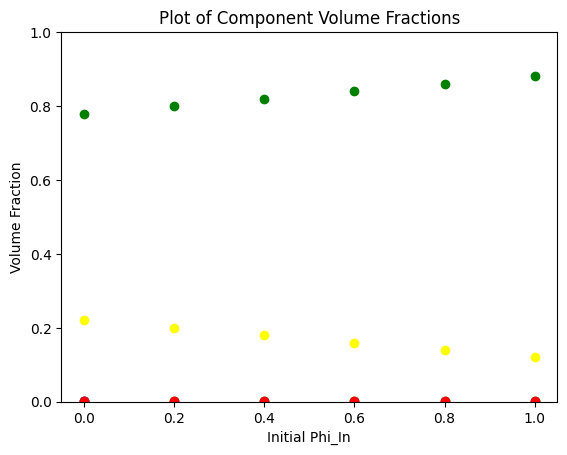

In [320]:



#bounds = [[0,0.4], [0,0.4], [0,0.4],[0,0.4]]
#bounds = [[0,0.4], [0,0.4], [0,0.4]]
bounds = [[0,0.4], [0,0.4]]
result_DE = differential_evolution(evolve_components_flory_loss,bounds = bounds, maxiter = 5, popsize = 2)

In [316]:
def evolve_components_flory_multi_out(phi_in_range, phi_out, phi_H, num_of_points,chi_strength,chi_matrix):
    num_comps = len(phi_H) + len(phi_out) + 1
    #generate comp_points
    
    phi_in_min = phi_in_range[0]
    phi_in_max = phi_in_range[1]
    # picks all the phi_in points given the threshold
    phi_in_points = np.linspace(phi_in_min,phi_in_max, num_of_points)
    phi_in_points = phi_in_points.reshape(num_of_points,1)
    # 
    phi_H_points = np.tile(phi_H, [num_of_points,1])
    out_array = np.tile(phi_out, [num_of_points, 1])

    
    # comp_points is all the points in the phase space that we are going to evolve
    comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
    #add solvent component
    phi_sol_points = []
    for phi_in in phi_in_points:
        phi_sol= 1 - (phi_in + sum(phi_out) + sum(phi_H)) 
        phi_sol_points.append(phi_sol)

    phi_sol_points = np.array(phi_sol_points)

    comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
    print(comp_points)
    norm_points = np.linspace(0,1, num_of_points)

    evolved_comp_points = []
    for point in (comp_points):
        phase = flory.find_coexisting_phases(num_comps+1,chi_matrix,point, progress = False)
        evolved_comp_points.append(phase)

    dilute_comp_points = []
    for phase in evolved_comp_points:
        x = gen.most_dilute_flory(phase)
        dilute_comp_points.append(x)
    
    dilute_out_comp_arr = np.array(dilute_comp_points)

    test_plot = plots.plot_comp_volume_fraction_v3(dilute_out_comp_arr,output_readout_func)

    
    return dilute_out_comp_arr
    

    
            